In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm  # For progress bars
from PIL import Image, ImageDraw
import random
from torchinfo import summary
import timm
from collections import Counter
from termcolor import colored

# Read Dataset

In [2]:
# Data directory
data_dir = "/kaggle/input/dog-and-cat-detection"
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

df.head()

,image_name
0,Cats_Test3283.png
1,Cats_Test727.png
2,Cats_Test1584.png
3,Cats_Test1196.png
4,Cats_Test2587.png


# Create PyTorch Dataset

In [3]:
class YOLOMergedImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None, S=7, B=1, C=2, seed=42):
        """
        YOLO format dataset that merges two single-object images horizontally.
        
        Args:
            annotations_dir: Directory containing XML annotations
            image_dir: Directory containing images
            transform: Image transformations
            S: Grid size (S x S)
            B: Number of bounding boxes per grid cell
            C: Number of classes (2 for cat/dog)
            seed: Random seed for reproducible image pairing
        """
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        
        # Class mapping for cat/dog
        self.class_mapping = {'cat': 0, 'dog': 1}
        
        # Set seed for reproducible pairing
        self.rng = random.Random(seed)
        
        self.image_files = self.filter_images_with_single_objects()
        
        if len(self.image_files) == 0:
            raise ValueError("No valid images found in the dataset")

    def filter_images_with_single_objects(self):
        """Filter images that have exactly one valid object (cat or dog)"""
        valid_image_files = []
        
        for f in os.listdir(self.image_dir):
            if not os.path.isfile(os.path.join(self.image_dir, f)):
                continue
                
            img_name = f
            annotation_name = os.path.splitext(img_name)[0] + ".xml"
            annotation_path = os.path.join(self.annotations_dir, annotation_name)
            
            try:
                if self.count_valid_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
                else:
                    print(f"Image {img_name} excluded: doesn't have exactly one cat/dog object")
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                
        return valid_image_files

    def count_valid_objects_in_annotation(self, annotation_path):
        """Count number of valid objects (cat/dog) in annotation"""
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                name = obj.find('name').text
                if name in self.class_mapping:
                    count += 1
            return count
        except (FileNotFoundError, ET.ParseError):
            return 0

    def parse_annotation(self, annotation_path):
        """Parse XML annotation and return class_id and normalized bbox in YOLO format"""
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            
            # Get image dimensions
            image_width = int(root.find('size/width').text)
            image_height = int(root.find('size/height').text)
            
            # Find the first valid object (cat or dog)
            for obj in root.findall('object'):
                name = obj.find('name').text
                if name in self.class_mapping:
                    class_id = self.class_mapping[name]
                    
                    # Get bounding box coordinates
                    xmin = int(obj.find('bndbox/xmin').text)
                    ymin = int(obj.find('bndbox/ymin').text)
                    xmax = int(obj.find('bndbox/xmax').text)
                    ymax = int(obj.find('bndbox/ymax').text)
                    
                    # Convert to YOLO format (center_x, center_y, width, height) normalized
                    x_center = (xmin + xmax) / 2.0 / image_width
                    y_center = (ymin + ymax) / 2.0 / image_height
                    width = (xmax - xmin) / image_width
                    height = (ymax - ymin) / image_height
                    
                    return class_id, [x_center, y_center, width, height]
                    
        except Exception as e:
            print(f"Error parsing annotation {annotation_path}: {e}")
            
        return None, None


    def __len__(self):
        return len(self.image_files)
        

    def __getitem__(self, idx):
        # Get first image
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)
        
        annotation_name = os.path.splitext(img1_file)[0] + ".xml"
        img1_class, img1_bbox = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )
        
        # Get second image (deterministic pairing based on index)
        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)
        
        annotation_name = os.path.splitext(img2_file)[0] + ".xml"
        img2_class, img2_bbox = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )
        
        # Load images
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
        
        # Horizontal merge
        merged_image = Image.new(
            "RGB", (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)
        
        # Adjust bounding boxes for the merged image
        merged_boxes = []
        
        # Adjust bbox for img1 (left side)
        if img1_class is not None and img1_bbox is not None:
            x_center = img1_bbox[0] * img1.width / merged_w
            y_center = img1_bbox[1] * img1.height / merged_h
            width = img1_bbox[2] * img1.width / merged_w
            height = img1_bbox[3] * img1.height / merged_h
            merged_boxes.append([img1_class, x_center, y_center, width, height])
        
        # Adjust bbox for img2 (right side)
        if img2_class is not None and img2_bbox is not None:
            x_center = (img2_bbox[0] * img2.width + img1.width) / merged_w
            y_center = img2_bbox[1] * img2.height / merged_h
            width = img2_bbox[2] * img2.width / merged_w
            height = img2_bbox[3] * img2.height / merged_h
            merged_boxes.append([img2_class, x_center, y_center, width, height])
        
        # Apply transforms to image
        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)
        
        # Create YOLO label matrix
        label_matrix = self.create_yolo_label_matrix(merged_boxes)
        
        return merged_image, label_matrix


    def create_yolo_label_matrix(self, boxes):
        """
        Create YOLO format label matrix from bounding boxes.
        
        Args:
            boxes: List of [class_id, x_center, y_center, width, height] in normalized coordinates
            
        Returns:
            torch.Tensor: Label matrix of shape (S, S, C + 5*B)
        """
        # Create empty label matrix
        # Format: [class_0, class_1, ..., class_C-1, 
        ## confidence_1, x_1, y_1, w_1, h_1, 
        ## confidence_2, x_2, y_2, w_2, h_2]
        
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        
        for box in boxes:
            if len(box) != 5:
                continue
                
            class_id, x_center, y_center, width, height = box
            class_id = int(class_id)
            
            # Calculate which grid cell this box belongs to
            i = int(self.S * y_center)  # row
            j = int(self.S * x_center)  # column
            
            # Ensure indices are within bounds
            i = min(max(i, 0), self.S - 1)
            j = min(max(j, 0), self.S - 1)
            
            # Calculate coordinates relative to the grid cell
            x_cell = self.S * x_center - j
            y_cell = self.S * y_center - i
            
            # Calculate width and height relative to the entire image (as in original YOLO)
            width_cell = width * self.S
            height_cell = height * self.S
            
            # If no object has been assigned to this grid cell yet
            if label_matrix[i, j, self.C] == 0:  # First bounding box confidence
                # Set class probability
                label_matrix[i, j, class_id] = 1.0
                
                # Set first bounding box
                label_matrix[i, j, self.C] = 1.0  # confidence
                label_matrix[i, j, self.C + 1] = x_cell  # x
                label_matrix[i, j, self.C + 2] = y_cell  # y
                label_matrix[i, j, self.C + 3] = width_cell  # width
                label_matrix[i, j, self.C + 4] = height_cell  # height
                
            elif self.B > 1 and label_matrix[i, j, self.C + 5] == 0:  # Second bounding box confidence
                # Set second bounding box
                label_matrix[i, j, self.C + 5] = 1.0  # confidence
                label_matrix[i, j, self.C + 6] = x_cell  # x
                label_matrix[i, j, self.C + 7] = y_cell  # y
                label_matrix[i, j, self.C + 8] = width_cell  # width
                label_matrix[i, j, self.C + 9] = height_cell  # height
        
        return label_matrix

In [4]:
# Step 1: Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


# Step 2: Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Step 3: Create datasets
train_dataset = YOLOMergedImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = YOLOMergedImageDataset(annotations_dir, image_dir, transform=transform)
test_dataset = YOLOMergedImageDataset(annotations_dir, image_dir, transform=transform)

# Step 4: Filter datasets based on split DataFrames
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]
test_dataset.image_files = [f for f in test_dataset.image_files if f in test_df['image_name'].values]

Image Cats_Test736.png excluded: doesn't have exactly one cat/dog object
Image Cats_Test736.png excluded: doesn't have exactly one cat/dog object
Image Cats_Test736.png excluded: doesn't have exactly one cat/dog object


In [5]:
# Example: Check the shape of one training sample
img, ann = train_dataset[0]
print("Training dataset length:", len(train_dataset))
print("Image shape:", img.shape)   # [C, H, W]
print("Annotations:", ann.shape)

# Example: Check the shape of one validation sample
img, ann = val_dataset[0]
print("Validation dataset length:", len(val_dataset))
print("Image shape:", img.shape)   # [C, H, W]
print("Annotations:", ann.shape)

# Example: Check the shape of one test sample
img, ann = test_dataset[0]
print("Test dataset length:", len(test_dataset))
print("Image shape:", img.shape)   # [C, H, W]
print("Annotations:", ann.shape)


Training dataset length: 2580
Image shape: torch.Size([3, 224, 224])
Annotations: torch.Size([7, 7, 7])
Validation dataset length: 552
Image shape: torch.Size([3, 224, 224])
Annotations: torch.Size([7, 7, 7])
Test dataset length: 553
Image shape: torch.Size([3, 224, 224])
Annotations: torch.Size([7, 7, 7])


Training Dataset Samples:


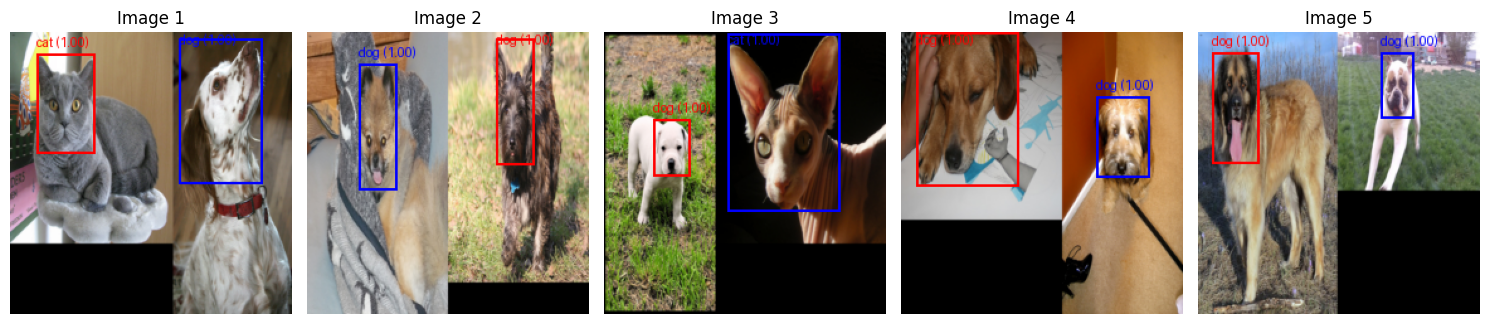


Validation Dataset Samples:


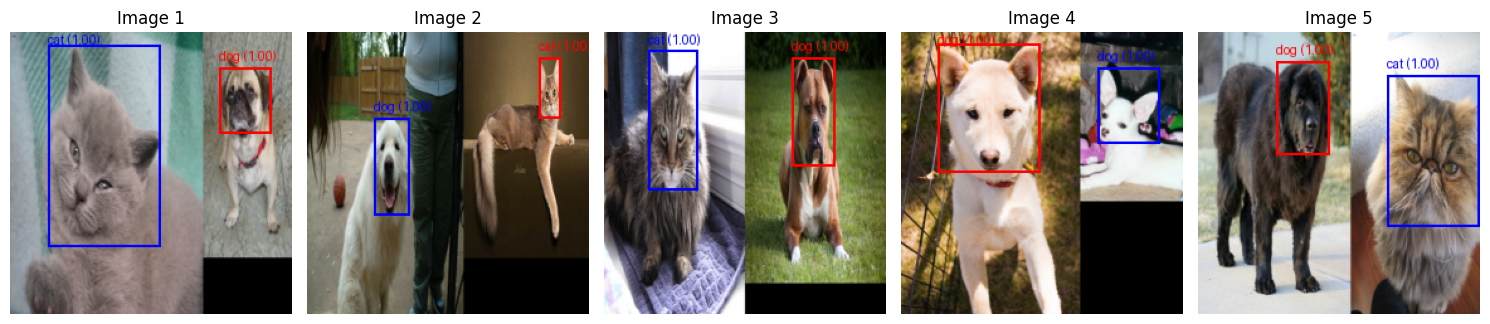


Test Dataset Samples:


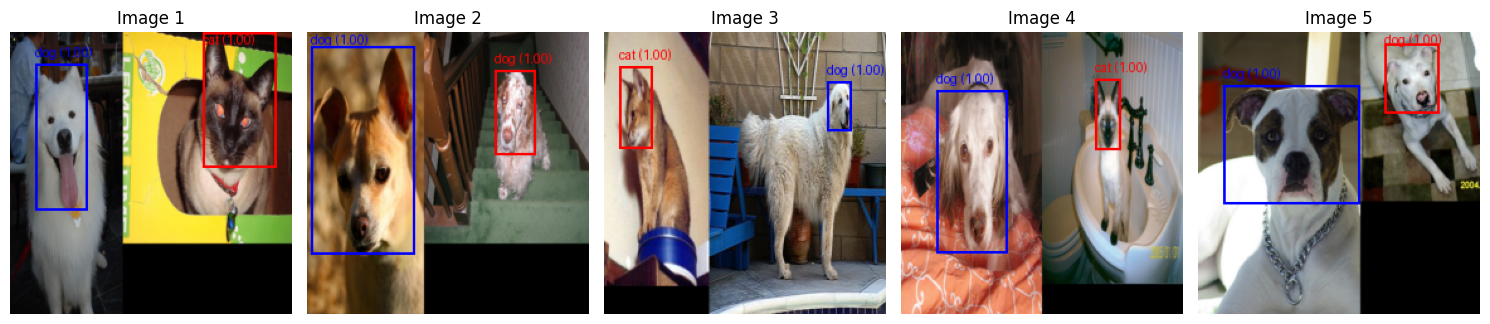

In [6]:
def labelmatrix_to_bbox(label_matrix, S=7, C=2, B=2, conf_threshold=0.1):
    """
    Convert YOLO label matrix back to bounding boxes for visualization.
    
    Args:
        label_matrix: (S, S, C + 5*B) tensor
        S: Grid size
        C: Number of classes
        B: Number of bounding boxes per cell
        conf_threshold: Confidence threshold for displaying boxes
        
    Returns:
        List of [class_id, x_center, y_center, width, height, confidence] in normalized coordinates
    """
    boxes = []
    
    for i in range(S):
        for j in range(S):
            cell = label_matrix[i, j]
            
            # Check first bounding box
            if cell[C] > conf_threshold:  # First box confidence
                # Get class with highest probability
                class_probs = cell[:C]
                class_id = torch.argmax(class_probs).item()
                
                # Get box coordinates (relative to cell)
                x_cell = cell[C + 1].item()
                y_cell = cell[C + 2].item()
                w_cell = cell[C + 3].item()
                h_cell = cell[C + 4].item()
                confidence = cell[C].item()
                
                # Convert to normalized coordinates (0-1)
                x_center = (j + x_cell) / S
                y_center = (i + y_cell) / S
                width = w_cell / S
                height = h_cell / S
                
                boxes.append([class_id, x_center, y_center, width, height, confidence])
            
            # Check second bounding box (if B > 1)
            if B > 1 and cell[C + 5] > conf_threshold:  # Second box confidence
                # Get class with highest probability
                class_probs = cell[:C]
                class_id = torch.argmax(class_probs).item()
                
                # Get box coordinates (relative to cell)
                x_cell = cell[C + 6].item()
                y_cell = cell[C + 7].item()
                w_cell = cell[C + 8].item()
                h_cell = cell[C + 9].item()
                confidence = cell[C + 5].item()
                
                # Convert to normalized coordinates (0-1)
                x_center = (j + x_cell) / S
                y_center = (i + y_cell) / S
                width = w_cell / S
                height = h_cell / S
                
                boxes.append([class_id, x_center, y_center, width, height, confidence])
    
    return boxes


def denormalize(tensor, mean, std):
    """
    Denormalize a tensor image with mean and std.
    """
    mean = torch.tensor(mean).reshape(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(-1, 1, 1).to(tensor.device)
    return tensor * std + mean


def show_images(dataset, num_images=5, show_bbox=True, S=7, C=2, B=2):
    """
    Show images from YOLO dataset with bounding boxes.
    
    Args:
        dataset: YOLOMergedImageDataset instance
        num_images: Number of images to display
        show_bbox: Whether to show bounding boxes
        S: Grid size (should match dataset)
        C: Number of classes (should match dataset)
        B: Number of bounding boxes per cell (should match dataset)
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    plt.figure(figsize=(15, 5))
    
    for i in range(min(num_images, len(dataset))):
        img, label_matrix = dataset[i]  # img: tensor, label_matrix: (S, S, C + 5*B)
        
        # Denormalize image
        img = denormalize(img, mean, std)
        img = torch.clamp(img, 0, 1)
        img_pil = TF.to_pil_image(img)
        width, height = img_pil.size
        
        if show_bbox:
            # Convert YOLO label matrix to bounding boxes
            boxes = labelmatrix_to_bbox(label_matrix, S=S, C=C, B=B, conf_threshold=0.1)
            
            draw = ImageDraw.Draw(img_pil)
            colors = ['red', 'blue', 'green', 'yellow', 'purple']  # Different colors for multiple boxes
            
            for idx, box in enumerate(boxes):
                class_id, x_center, y_center, box_width, box_height, confidence = box
                
                # Convert center coordinates to corner coordinates
                xmin = int((x_center - box_width/2) * width)
                ymin = int((y_center - box_height/2) * height)
                xmax = int((x_center + box_width/2) * width)
                ymax = int((y_center + box_height/2) * height)
                
                # Ensure coordinates are within image bounds
                xmin = max(0, min(xmin, width-1))
                ymin = max(0, min(ymin, height-1))
                xmax = max(0, min(xmax, width-1))
                ymax = max(0, min(ymax, height-1))
                
                color = colors[idx % len(colors)]
                
                # Draw bounding box
                draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
                
                # Draw label with confidence
                label_text = f"{'cat' if class_id == 0 else 'dog'} ({confidence:.2f})"
                
                # Calculate text position (avoid going outside image)
                text_y = max(0, ymin - 15)
                draw.text((xmin, text_y), label_text, fill=color)
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_pil)
        plt.axis("off")
        plt.title(f"Image {i+1}")
    
    plt.tight_layout()
    plt.show()


# Usage with your datasets
print("Training Dataset Samples:")
show_images(train_dataset, num_images=5, show_bbox=True, S=7, C=2, B=1)

print("\nValidation Dataset Samples:")
show_images(val_dataset, num_images=5, show_bbox=True, S=7, C=2, B=1)

print("\nTest Dataset Samples:")
show_images(test_dataset, num_images=5, show_bbox=True, S=7, C=2, B=1)

# Create DataLoader

In [7]:
batch_size = 384

In [8]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Get one batch from the train loader
for images, annotations in train_loader:
    print("Train batch - images shape:", images.shape)          # [B, C, H, W]
    print("Train batch - annotations shape:", annotations.shape)  # [B, 2, 5]
    break  # Only print first batch

# Get one batch from the val loader
for images, annotations in val_loader:
    print("Val batch - images shape:", images.shape)
    print("Val batch - annotations shape:", annotations.shape)
    break

# Get one batch from the test loader
for images, annotations in test_loader:
    print("Test batch - images shape:", images.shape)
    print("Test batch - annotations shape:", annotations.shape)
    break

Train batch - images shape: torch.Size([384, 3, 224, 224])
Train batch - annotations shape: torch.Size([384, 7, 7, 7])
Val batch - images shape: torch.Size([384, 3, 224, 224])
Val batch - annotations shape: torch.Size([384, 7, 7, 7])
Test batch - images shape: torch.Size([384, 3, 224, 224])
Test batch - annotations shape: torch.Size([384, 7, 7, 7])


# Create Model

In [10]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        """
        Initializes the YOLOV1 model with ResNet34 as the backbone.
        
        Args:
            in_channels (int): Number of input channels. Default is 3 for RGB images.
            **kwargs: Additional keyword arguments such as split_size, num_boxes, num_classes.
        """
        super(Yolov1, self).__init__()
        self.split_size = kwargs.get("split_size", 7)  # S
        self.num_boxes = kwargs.get("num_boxes", 1)   # B
        self.num_classes = kwargs.get("num_classes", 20)  # C
        
        # Initialize ResNet34 backbone from timm
        # `features_only=True` returns a list of feature maps from specified stages
        # `out_indices=[4]` corresponds to the last layer's output
        self.backbone = timm.create_model(
            "resnet34",
            pretrained=True,
            features_only=True,
            out_indices=[4],
            in_chans=in_channels,
        )
        
        # Adaptive pooling to ensure the spatial dimensions match (S x S)
        self.pool = nn.AdaptiveAvgPool2d((self.split_size, self.split_size))
        
        # Fully connected layers
        self.fcs = self._create_fcs()

    def _create_fcs(self):
        """
        Creates the fully connected layers for YOLOv1.
        
        Returns:
            nn.Sequential: Sequential container of fully connected layers.
        """
        S, B, C = self.split_size, self.num_boxes, self.num_classes
        
        # Calculate the input features for the first linear layer
        # ResNet34's last feature map has 512 channels
        # After pooling to (S x S), the total features are 512 * S * S
        input_features = 512 * S * S
        
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_features, 4096),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(4096, S * S * (C + B * 5)),
        )

    @torch.autocast(device_type="cuda", dtype=torch.float16)
    def forward(self, x):
        """
        Forward pass of the YOLOv1 model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W).
            
        Returns:
            torch.Tensor: Output tensor containing bounding box predictions.
        """
        # Extract features using ResNet34 backbone
        features = self.backbone(x)[
            0
        ]  # timm returns a list; take the first (and only) element
        
        # Apply adaptive pooling to match spatial dimensions
        pooled_features = self.pool(features)
        
        # Pass through fully connected layers
        output = self.fcs(pooled_features)
        
        return output

In [11]:
# Create the model with desired kwargs
model = Yolov1(num_boxes=1, split_size=7, num_classes=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
summary(model, input_size=(1, 3, 224, 224))  # Batch size = 1, 3-channel image

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Layer (type:depth-idx)                        Output Shape              Param #
Yolov1                                        [1, 343]                  --
├─FeatureListNet: 1-1                         [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-3                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]          230,144

# Post Process

In [12]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculate the Intersection over Union (IoU) between bounding boxes.
    
    Parameters:
        boxes_preds (tensor): Predicted bounding boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Ground truth bounding boxes (BATCH_SIZE, 4)
        box_format (str): Box format, can be "midpoint" or "corners".
    
    Returns:
        tensor: Intersection over Union scores for each example.
    """
    
    # Check if the box format is "midpoint"
    if box_format == "midpoint":
        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2)
        # points for predicted boxes
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        
        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2)
        # points for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    # Check if the box format is "corners"
    if box_format == "corners":
        # Extract coordinates for predicted boxes
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        
        # Extract coordinates for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    # Calculate coordinates of the intersection rectangle
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    # Compute the area of the intersection rectangle, clamp(0) to handle cases
    # where they do not overlap
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    # Calculate the areas of the predicted and ground truth boxes
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    # Calculate the Intersection over Union, adding a small epsilon to avoid
    # division by zero
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [13]:
def non_max_suppression(bboxes, iou_threshold, confidence_threshold, box_format="corners"):
    """
    Perform Non-Maximum Suppression (NMS) to filter overlapping bounding boxes.
    
    Args:
        bboxes (list): List of bounding boxes, each containing [class_id, confidence, x1, y1, x2, y2]
        iou_threshold (float): IoU threshold to determine box overlap
        confidence_threshold (float): Minimum confidence score to keep a box
        box_format (str): Format of box coordinates - "corners" or "midpoint"
    
    Returns:
        list: Filtered list of bounding boxes after NMS
    """
    if not isinstance(bboxes, list):
        raise TypeError("bboxes must be a list")
    
    # Keep only high confidence predictions
    confident_boxes = [box for box in bboxes if box[1] > confidence_threshold]
    
    # Sort by confidence score (highest first)
    confident_boxes.sort(key=lambda x: x[1], reverse=True)

    kept_boxes = []

    while confident_boxes:
        # Take box with highest confidence
        best_box = confident_boxes.pop(0)
        
        # Keep remaining boxes that either:
        # 1. Are from a different class OR
        # 2. Don't overlap significantly with the best box
        confident_boxes = [
            box for box in confident_boxes
            if (box[0] != best_box[0]) or  # Different class
            (intersection_over_union(
                torch.tensor(best_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format
            ) < iou_threshold)  # Low overlap
        ]
        
        kept_boxes.append(best_box)
    
    return kept_boxes

In [14]:
def get_bboxes_training(predictions, targets, iou_threshold, threshold, S=7, B=1, C=2):
    """
    Convert YOLO model predictions and targets to bounding box format for mAP calculation.
    Uses existing labelmatrix_to_bbox function to avoid code duplication.
    
    Args:
        predictions (torch.Tensor): Model predictions of shape (batch_size, S*S*(C+B*5))
        targets (torch.Tensor): Ground truth labels of shape (batch_size, S, S, C+B*5)
        iou_threshold (float): IoU threshold for NMS
        threshold (float): Confidence threshold for filtering predictions
        S (int): Grid size
        B (int): Number of bounding boxes per grid cell
        C (int): Number of classes
    
    Returns:
        tuple: (pred_boxes, true_boxes) where each is a list of 
               [train_idx, class_pred, confidence, x1, y1, x2, y2]
    """
    batch_size = predictions.shape[0]
    
    # Reshape predictions to (batch_size, S, S, C + B*5)
    predictions = predictions.reshape(batch_size, S, S, C + B * 5)
    
    pred_boxes = []
    true_boxes = []
    
    for batch_idx in range(batch_size):
        # Process predictions using existing labelmatrix_to_bbox function
        pred_bbox_list = labelmatrix_to_bbox(
            predictions[batch_idx], S=S, C=C, B=B, conf_threshold=threshold
        )
        
        # Convert to format expected by mAP: [train_idx, class_pred, confidence, x1, y1, x2, y2]
        for bbox in pred_bbox_list:
            class_id, x_center, y_center, width, height, confidence = bbox
            
            # Convert from midpoint to corner format
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2
            
            # Clamp coordinates to [0, 1] range
            x1 = max(0, min(1, x1))
            y1 = max(0, min(1, y1))
            x2 = max(0, min(1, x2))
            y2 = max(0, min(1, y2))
            
            pred_boxes.append([batch_idx, class_id, confidence, x1, y1, x2, y2])
        
        # Process ground truth using existing labelmatrix_to_bbox function
        true_bbox_list = labelmatrix_to_bbox(
            targets[batch_idx], S=S, C=C, B=B, conf_threshold=0.0  # Include all ground truth boxes
        )
        
        # Convert to format expected by mAP
        for bbox in true_bbox_list:
            class_id, x_center, y_center, width, height, confidence = bbox
            
            # Convert from midpoint to corner format
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2
            
            # Clamp coordinates to [0, 1] range
            x1 = max(0, min(1, x1))
            y1 = max(0, min(1, y1))
            x2 = max(0, min(1, x2))
            y2 = max(0, min(1, y2))
            
            true_boxes.append([batch_idx, class_id, confidence, x1, y1, x2, y2])
    
    # Apply Non-Maximum Suppression to predictions
    # Group predictions by batch and class for NMS
    nms_pred_boxes = []
    for batch_idx in range(batch_size):
        batch_preds = [box for box in pred_boxes if box[0] == batch_idx]
        
        # Group by class
        for class_id in range(C):
            class_preds = [box for box in batch_preds if box[1] == class_id]
            
            if class_preds:
                # Convert to format expected by NMS: [class_id, confidence, x1, y1, x2, y2]
                nms_input = [[box[1], box[2]] + box[3:] for box in class_preds]
                
                # Apply NMS
                nms_output = non_max_suppression(
                    nms_input, 
                    iou_threshold=iou_threshold, 
                    confidence_threshold=threshold,
                    box_format="corners"
                )
                
                # Convert back to original format and add batch index
                for box in nms_output:
                    nms_pred_boxes.append([batch_idx] + box)
    
    return nms_pred_boxes, true_boxes

# Training and Evaluation

**Loss Function**

In [15]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=1, C=2):  # Changed C=2 for cat/dog
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = 5
        self.lambda_noobj = 0.5

    def forward(self, predictions, target):
        # Reshape the predictions to the shape (BATCH_SIZE, S*S*(C+B*5))
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        
        # Calculate Intersection over Union (IoU) for the predicted bounding boxes
        # with the target bounding box.
        iou_b1 = intersection_over_union(predictions[..., self.C+1:self.C+5], target[..., self.C+1:self.C+5])
        
        if self.B > 1:
            iou_b2 = intersection_over_union(predictions[..., self.C+6:self.C+10], target[..., self.C+1:self.C+5])
            ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
            # Get the box with the highest IoU among the predictions.
            iou_maxes, bestbox = torch.max(ious, dim=0)
        else:
            # Only one bounding box, so bestbox is always 0
            bestbox = torch.zeros_like(iou_b1)
            iou_maxes = iou_b1
        
        exists_box = target[..., self.C].unsqueeze(3)  # This represents Iobj_i in the paper

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set the boxes with no objects to zero. Choose between predictions based on B value
        if self.B > 1:
            box_predictions = exists_box * (
                bestbox * predictions[..., self.C+6:self.C+10]
                + (1 - bestbox) * predictions[..., self.C+1:self.C+5]
            )
        else:
            # Only one bounding box prediction
            box_predictions = exists_box * predictions[..., self.C+1:self.C+5]

        box_targets = exists_box * target[..., self.C+1:self.C+5]

        # Take the square root of width and height to ensure positive values.
        box_predictions_xy = box_predictions[..., :2]  # x, y coordinates (unchanged)
        box_predictions_wh = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4]) + 1e-6
        )
        box_predictions = torch.cat([box_predictions_xy, box_predictions_wh], dim=-1)
        
        box_targets_xy = box_targets[..., :2]  # x, y coordinates (unchanged)
        box_targets_wh = torch.sqrt(box_targets[..., 2:4])
        box_targets = torch.cat([box_targets_xy, box_targets_wh], dim=-1)

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box represents confidence score of the box with the highest IoU.
        if self.B > 1:
            pred_box = (
                bestbox * predictions[..., self.C+5:self.C+6] + (1 - bestbox) * predictions[..., self.C:self.C+1]
            )
        else:
            # Only one confidence score to consider
            pred_box = predictions[..., self.C:self.C+1]

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C+1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C+1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C+1], start_dim=1),
        )

        if self.B > 1:
            no_object_loss += self.mse(
                torch.flatten((1 - exists_box) * predictions[..., self.C+5:self.C+6], start_dim=1),
                torch.flatten((1 - exists_box) * target[..., self.C:self.C+1], start_dim=1)
            )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2),  # Only first 2 classes
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2),      # Only first 2 classes
        )

        # Calculate the final loss by combining the above components.
        loss = (
            self.lambda_coord * box_loss  # First term
            + object_loss  # Second term
            + self.lambda_noobj * no_object_loss  # Third term
            + class_loss  # Fourth term
        )

        return loss

**Metric Function**

In [16]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=20
):
    """
    Calculate the mean average precision (mAP).

    Parameters:
        pred_boxes (list): A list containing predicted bounding boxes with each
            box defined as [train_idx, class_pred, prob_score, x1, y1, x2, y2].
        true_boxes (list): Similar to pred_boxes but containing information about
            true boxes.
        iou_threshold (float): IoU threshold, where predicted boxes are
            considered correct.
        box_format (str): "midpoint" or "corners" used to specify the format
            of the boxes.
        num_classes (int): Number of classes.

    Returns:
        float: The mAP value across all classes with a specific IoU threshold.
    """

    # List to store AP for each class
    average_precisions = []

    # Small epsilon to stabilize division
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Iterate through all predictions and targets, and only add those
        # belonging to
        # the current class 'c',
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Find the number of boxes for each training example.
        # The Counter here counts the number of target boxes we have
        # # for each training example, so if image 0 has 3, and image 1 has 5,
        # # we'll have a dictionary like:
        # # amount_bboxes = {0: 3, 1: 5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then loop through each key, val in this dictionary and convert it to
        # the following (for the same example):
        # # amount_bboxes = {0: torch.tensor([0, 0, 0]), 1: torch.tensor([0, 0, 0,
        # 0, 0])}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sort by box probability, index 2 is the probability
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))
        total_true_boxes = len(ground_truths)

        # If there are no ground truth boxes for this class, it can be safely
        # skipped
        if total_true_boxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only consider ground truth boxes with the same training index as
            # the prediction
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # Only detect ground truth once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            # If IOU is lower, the detection result is false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_boxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # Use torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [17]:
def train_fn(train_loader, model, optimizer, loss_fn, epoch):
    model.train()
    mean_loss = []
    mean_mAP = []

    total_batches = len(train_loader)
    display_interval = total_batches // 5  # Update after 20% of the total
                                          # batches.

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_boxes, true_boxes = get_bboxes_training(out, y, iou_threshold=0.5,
                                                   threshold=0.4)
        mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5,
                                     box_format="midpoint")

        mean_loss.append(loss.item())
        mean_mAP.append(mAP.item())

        if batch_idx % display_interval == 0 or batch_idx == total_batches - 1:
            print(f"Epoch: {epoch:3} \t Iter: {batch_idx:3}/{total_batches:3} \t "
                  f"Loss: {loss.item():3.10f} \t mAP: {mAP.item():3.10f}")

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)
    print(colored(f"Train \t Loss: {avg_loss:3.10f} \t mAP: {avg_mAP:3.10f}",
                  'green'))

    return avg_mAP


def test_fn(test_loader, model, loss_fn, epoch):
    model.eval()
    mean_loss = []
    mean_mAP = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)

        pred_boxes, true_boxes = get_bboxes_training(out, y, iou_threshold=0.5,
                                                   threshold=0.4)
        mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5,
                                     box_format="midpoint")

        mean_loss.append(loss.item())
        mean_mAP.append(mAP.item())

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)
    print(colored(f"Test \t Loss: {avg_loss:3.10f} \t mAP: {avg_mAP:3.10f}",
                  'yellow'))

    return avg_mAP

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [18]:
# Set the random seed for reproducibility.
seed = 123
torch.manual_seed(seed)

# Hyperparameters and configurations
# Learning rate for the optimizer.
LEARNING_RATE = 2e-5
# Specify whether to use "cuda" (GPU) or "cpu" for training.
DEVICE = device
# Number of training epochs.
EPOCHS = 50
# If False, the training process will not load a pre-trained model.
LOAD_MODEL = False
# Specify the file name for the pre-trained model if LOAD_MODEL is True.
LOAD_MODEL_FILE = "/kaggle/working/yolov1.pth.tar"

In [19]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = YoloLoss()

best_mAP_train = 0
best_mAP_val = 0
best_mAP_test = 0

# Training loop
for epoch in range(EPOCHS):
    train_mAP = train_fn(train_loader, model, optimizer, loss_fn, epoch)
    val_mAP = test_fn(val_loader, model, loss_fn, epoch)
    test_mAP = test_fn(test_loader, model, loss_fn, epoch)
    # Pass is_test=True for test set

    # Update best mAP values
    if train_mAP > best_mAP_train:
        best_mAP_train = train_mAP
    if val_mAP > best_mAP_val:
        best_mAP_val = val_mAP
        # Save checkpoint when validation mAP improves
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    if test_mAP > best_mAP_test:
        best_mAP_test = test_mAP


print(colored(f"Best Train mAP: {best_mAP_train:3.10f}", 'green'))
print(colored(f"Best Val mAP: {best_mAP_val:3.10f}", 'blue'))
print(colored(f"Best Test mAP: {best_mAP_test:3.10f}", 'yellow'))

Epoch:   0 	 Iter:   0/  7 	 Loss: 23418.4238281250 	 mAP: 0.0000117651
Epoch:   0 	 Iter:   1/  7 	 Loss: 12634.7167968750 	 mAP: 0.0005107532
Epoch:   0 	 Iter:   2/  7 	 Loss: 8539.7089843750 	 mAP: 0.0017041039
Epoch:   0 	 Iter:   3/  7 	 Loss: 6861.8071289062 	 mAP: 0.0070444327
Epoch:   0 	 Iter:   4/  7 	 Loss: 5823.9248046875 	 mAP: 0.0234841686
Epoch:   0 	 Iter:   5/  7 	 Loss: 5212.8774414062 	 mAP: 0.0400464498
Epoch:   0 	 Iter:   6/  7 	 Loss: 3379.3320312500 	 mAP: 0.0588827170
Train 	 Loss: 9410.1130022321 	 mAP: 0.0188120557
Test 	 Loss: 3123.5221557617 	 mAP: 0.0586568303
Test 	 Loss: 3023.9738159180 	 mAP: 0.0605544932
=> Saving checkpoint
Epoch:   1 	 Iter:   0/  7 	 Loss: 4592.6831054688 	 mAP: 0.0683612302
Epoch:   1 	 Iter:   1/  7 	 Loss: 4248.3500976562 	 mAP: 0.0715114400
Epoch:   1 	 Iter:   2/  7 	 Loss: 4030.1828613281 	 mAP: 0.0888654143
Epoch:   1 	 Iter:   3/  7 	 Loss: 3934.2863769531 	 mAP: 0.0873272121
Epoch:   1 	 Iter:   4/  7 	 Loss: 4107.59667968

# Inference

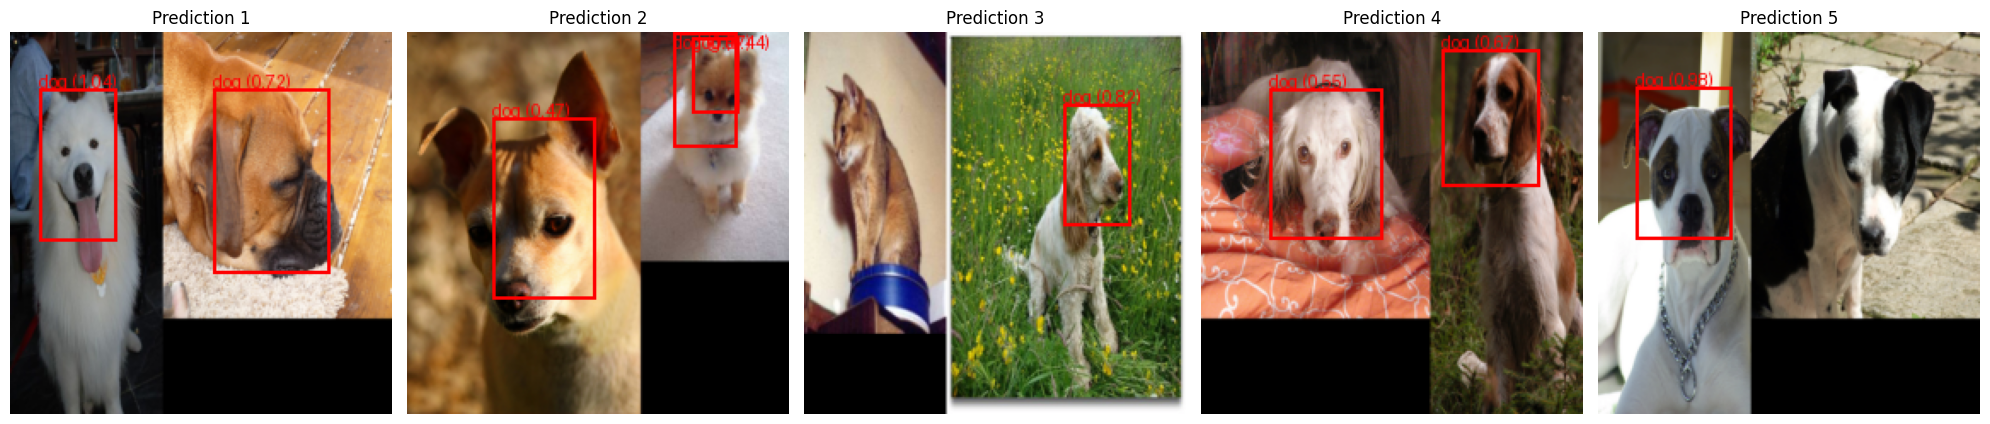

In [20]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from PIL import ImageDraw
import torch.nn.functional as F

# Load model weights
ckpt = torch.load(LOAD_MODEL_FILE, map_location=device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

# Class label mapping
idx_to_class = {0: 'cat', 1: 'dog'}

# Mean and std used in transforms (for denormalization)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

# Inference on 5 validation images
plt.figure(figsize=(20, 8))

for i in range(5):
    image, _ = test_dataset[i]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)  # Shape: [1, S * S * (C + B*5)]
        S, C, B = model.split_size, model.num_classes, model.num_boxes
        output = output.view(S, S, C + B * 5).cpu()

    # Convert YOLO grid predictions to list of bounding boxes
    raw_boxes = labelmatrix_to_bbox(output, S=S, C=C, B=B, conf_threshold=0.4)

    # Convert to NMS-compatible format: [class_id, confidence, x1, y1, x2, y2]
    nms_boxes = []
    for box in raw_boxes:
        class_id, x_center, y_center, width, height, confidence = box
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        nms_boxes.append([class_id, confidence, x1, y1, x2, y2])

    # Apply NMS
    final_boxes = non_max_suppression(nms_boxes, iou_threshold=0.5, confidence_threshold=0.4)

    # Denormalize image
    image = denormalize(image, mean, std)
    image = torch.clamp(image, 0, 1)
    img_pil = TF.to_pil_image(image)
    draw = ImageDraw.Draw(img_pil)
    W, H = img_pil.size

    # Draw final boxes
    for box in final_boxes:
        class_id, confidence, x1, y1, x2, y2 = box

        xmin = int(x1 * W)
        ymin = int(y1 * H)
        xmax = int(x2 * W)
        ymax = int(y2 * H)

        xmin = max(0, min(xmin, W - 1))
        ymin = max(0, min(ymin, H - 1))
        xmax = max(0, min(xmax, W - 1))
        ymax = max(0, min(ymax, H - 1))

        # Skip invalid boxes
        if xmax <= xmin or ymax <= ymin:
            continue

        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        label = f"{idx_to_class[class_id]} ({confidence:.2f})"
        draw.text((xmin, max(0, ymin - 10)), label, fill="red")

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title(f"Prediction {i+1}")

plt.tight_layout()
plt.show()